# Example of spatial analysis on a region in pancreatic cancer

## Note: calculating mpp for the slide

The slide we are interested in does not have the property "openslide.mpp-x", so instead, I used `tiff.ResolutionUnit` along with `tiff.XResolution`. The resolution unit is centimeters, and xresolution (I think) is pixels per resolution unit. So I did this...

$$
\frac{ResolutionUnit}{XResolution} * \frac{N micrometer}{ResolutionUnit}
$$

where $N micrometer$ is the number of micrometers in one unit of $ResolutionUnit$.

In our case, this was

$$
\frac{1 cm}{2883.244194 pix} * \frac{10,000 \mu m}{1 cm} = 0.34622 \frac{\mu m}{pix}
$$

In [1]:
from pathlib import Path
import tumor_microenv as tm

In [2]:
data_root = Path("data") / "Data2"
patch_paths = list(data_root.glob("*.npy"))
json_paths = list(data_root.glob("*.json"))

loader = tm.LoaderV1(
    patch_paths=patch_paths, 
    cells_json=json_paths, 
    background=0, 
    marker_positive=1, 
    marker_negative=7,
    marker_neg_thresh=0.3,
)
patches, cells = loader()
# Optionally filter cells by some condition.
cells = [c for c in cells if c.cell_type in {"cd4", "cd8", "cd16", "cd163"}]

In [3]:
# This takes several minutes.
tm.run_spatial_analysis(
    patches, 
    cells, 
    microenv_distances=[100], 
    mpp=0.34622,
    output_path="output.csv")

Distance = 100 um (289 px)


In [4]:
!du -sh output.csv

203M	output.csv


## Plot results

We plot a random point from each cell. This makes it easier to visualize the results.

In [19]:
import itertools
import random
import matplotlib.pyplot as plt

def gen_random_point_per_cell(points_data):
    for uuid, g in itertools.groupby(points_data, lambda p: p.cell_uuid):
        yield random.choice(list(g))

def plot(patches, points_data):
    import shapely.wkt
    
    tumor_colors = {
        tm.BiomarkerStatus.NA: "white",
        tm.BiomarkerStatus.POSITIVE: "brown",
        tm.BiomarkerStatus.NEGATIVE: "cyan",
    }

    cell_colors = {
        "cd4": "black",
        "cd8": "purple",
        "cd16": "yellow",
        "cd163": "yellow",
    }
    for patch in patches:
        # Plot tumor patches.
        if patch.patch_type == tm.PatchType.TUMOR:
            plt.fill(*patch.polygon.exterior.xy, color=tumor_colors[patch.biomarker_status])
    # Plot the point we are interested in.
    for point_data in points_data:
        if point_data.cell_type != "cd16":
            continue
        point = shapely.wkt.loads(point_data.point)
        # Plot line to the nearest marker-positive region.
        line_to_pos = shapely.wkt.loads(point_data.line_to_marker_pos)
        plt.plot(*line_to_pos.xy, color="brown", linestyle="--", linewidth=1, alpha=0.4)
        # Plot line to the nearest marker-negative region.
        line_to_neg = shapely.wkt.loads(point_data.line_to_marker_neg)
        plt.plot(*line_to_neg.xy, color="cyan", linestyle="--", linewidth=1, alpha=0.4)
        # Plot the point on top of the two lines.
#         plt.plot(point.x, point.y, color=cell_colors[point_data.cell_type], 
#                  marker="o", label=point_data.cell_type, alpha=0.2, )

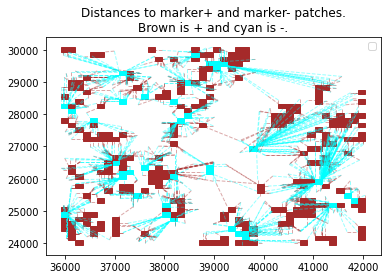

In [20]:
points_data = tm.read_point_csv("output.csv")
random_points_per_cell = list(gen_random_point_per_cell(points_data))
plot(patches, random_points_per_cell)

# Get unique legend labels. See https://stackoverflow.com/a/13589144/5666087
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc=1)
plt.title("Distances to marker+ and marker- patches.\nBrown is + and cyan is -.")
plt.savefig("/tmp/distances.pdf")
plt.show()

# Make histograms from output CSV

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [46]:
df = pd.read_csv("tumor-microenv-output-20210826.csv.gz")
df.head()

,point,dist_to_marker_neg,dist_to_marker_pos,line_to_marker_neg,line_to_marker_pos,cell_type,cell_uuid,microenv_micrometer
0,POINT (38253 25652),337.0,247.0,"LINESTRING (38253 25652, 38253 25989)","LINESTRING (38253 25652, 38253 25405)",cd16,d2503349108e4b5d987e4a99794c8ef9,100
1,POINT (38253 25653),336.0,248.0,"LINESTRING (38253 25653, 38253 25989)","LINESTRING (38253 25653, 38253 25405)",cd16,d2503349108e4b5d987e4a99794c8ef9,100
2,POINT (38253 25654),335.0,249.0,"LINESTRING (38253 25654, 38253 25989)","LINESTRING (38253 25654, 38253 25405)",cd16,d2503349108e4b5d987e4a99794c8ef9,100
3,POINT (38253 25655),334.0,250.0,"LINESTRING (38253 25655, 38253 25989)","LINESTRING (38253 25655, 38253 25405)",cd16,d2503349108e4b5d987e4a99794c8ef9,100
4,POINT (38253 25656),333.0,251.0,"LINESTRING (38253 25656, 38253 25989)","LINESTRING (38253 25656, 38253 25405)",cd16,d2503349108e4b5d987e4a99794c8ef9,100


In [91]:
df.shape

(1236644, 8)

In [93]:
df_cd16 = df.query("cell_type=='cd16'")
df_cd16.head()

,point,dist_to_marker_neg,dist_to_marker_pos,line_to_marker_neg,line_to_marker_pos,cell_type,cell_uuid,microenv_micrometer
0,POINT (38253 25652),337.0,247.0,"LINESTRING (38253 25652, 38253 25989)","LINESTRING (38253 25652, 38253 25405)",cd16,d2503349108e4b5d987e4a99794c8ef9,100
1,POINT (38253 25653),336.0,248.0,"LINESTRING (38253 25653, 38253 25989)","LINESTRING (38253 25653, 38253 25405)",cd16,d2503349108e4b5d987e4a99794c8ef9,100
2,POINT (38253 25654),335.0,249.0,"LINESTRING (38253 25654, 38253 25989)","LINESTRING (38253 25654, 38253 25405)",cd16,d2503349108e4b5d987e4a99794c8ef9,100
3,POINT (38253 25655),334.0,250.0,"LINESTRING (38253 25655, 38253 25989)","LINESTRING (38253 25655, 38253 25405)",cd16,d2503349108e4b5d987e4a99794c8ef9,100
4,POINT (38253 25656),333.0,251.0,"LINESTRING (38253 25656, 38253 25989)","LINESTRING (38253 25656, 38253 25405)",cd16,d2503349108e4b5d987e4a99794c8ef9,100


In [111]:
def get_pdf_and_cdf(values, bins=100):
    values = np.asarray(values)
    count, bins = np.histogram(values, bins=100)
    pdf = count / count.sum()
    cdf = pdf.cumsum()
    return pdf, cdf, bins

def plot_pdf_cdf(pdf, cdf, bins, cell_type, marker_type, ax):
    ax.plot(bins[1:], pdf, color="red", label="PDF")
    ax.plot(bins[1:], cdf, label="CDF")
    ax.legend()
    ax.set_xlabel("Distance (micrometer)")
    ax.set_title(f"{cell_type} distance to marker {marker_type}")
    return ax

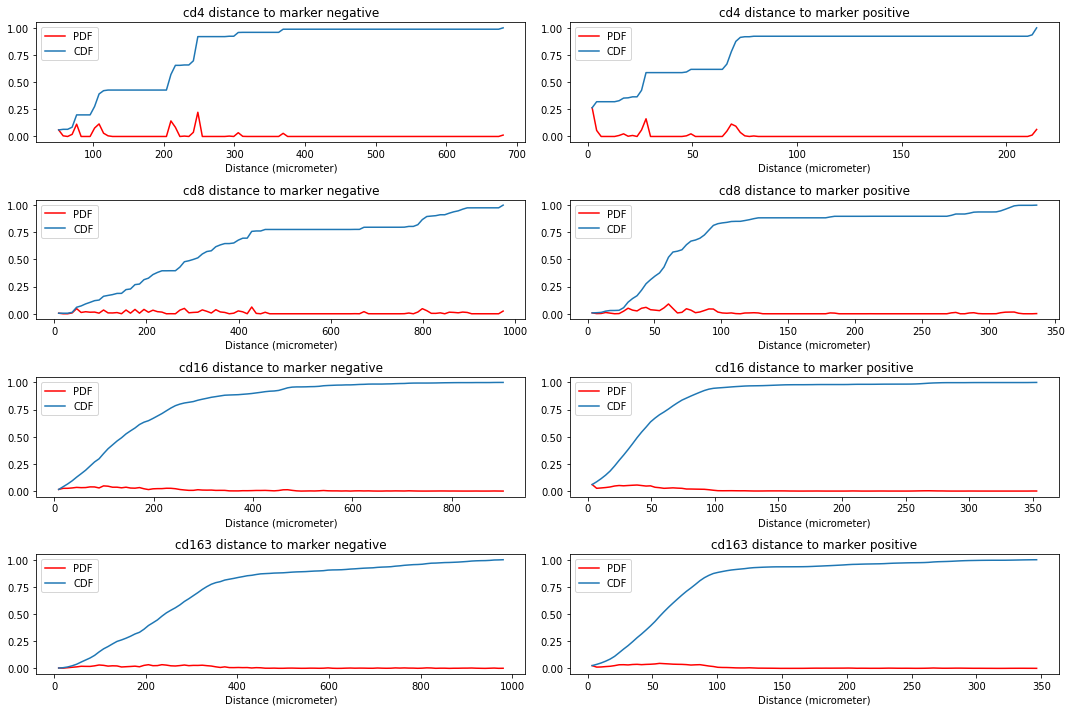

In [112]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 10))
cell_types = ["cd4", "cd8", "cd16", "cd163"]
for i, cell_type in enumerate(cell_types):
    for j, (marker_status, column)  in enumerate(
        [("negative", "dist_to_marker_neg"), ("positive", "dist_to_marker_pos")]):
        
        # Multiply pixels by mpp to get distance in micrometers.
        pdf, cdf, bins = get_pdf_and_cdf(df.query(f"cell_type=='{cell_type}'").loc[:, column] * 0.34622)
        plot_pdf_cdf(pdf, cdf, bins, cell_type=cell_type, marker_type=marker_status, ax=axes[i, j])
fig.tight_layout()

### Plot again but now with one plot per cell type (include M+ and M- in same plot)

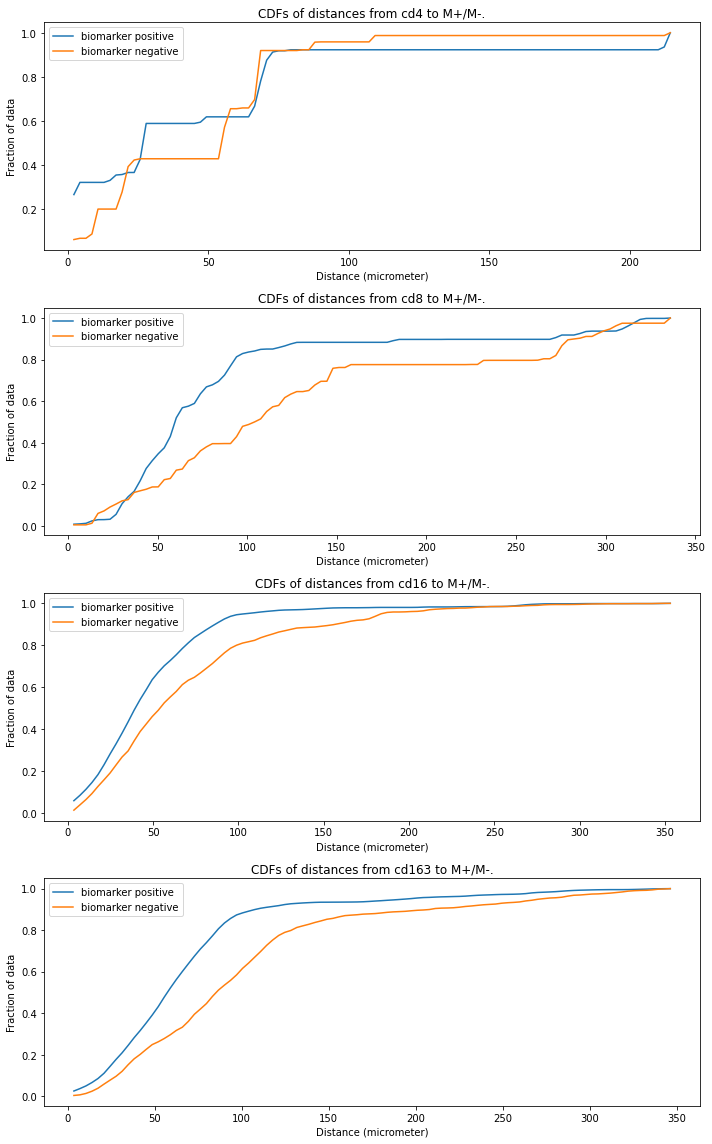

In [113]:
def plot_cdfs_per_celltype(cdf_pos, cdf_neg, bins, cell_type, ax):
    ax.plot(bins[1:], cdf_pos, label="biomarker positive")
    ax.plot(bins[1:], cdf_neg, label="biomarker negative")
    ax.legend()
    ax.set_xlabel("Distance (micrometer)")
    ax.set_ylabel("Fraction of data")
    ax.set_title(f"CDFs of distances from {cell_type} to M+/M-.")
    return ax

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 16))
cell_types = ["cd4", "cd8", "cd16", "cd163"]
for i, cell_type in enumerate(cell_types):
    _tmp_df = df.query(f"cell_type=='{cell_type}'")
    _, cdf_neg, bins = get_pdf_and_cdf(_tmp_df.loc[:, "dist_to_marker_neg"] * 0.34622)
    _, cdf_pos, bins = get_pdf_and_cdf(_tmp_df.loc[:, "dist_to_marker_pos"] * 0.34622)
    plot_cdfs_per_celltype(
        cdf_pos=cdf_pos, cdf_neg=cdf_neg, bins=bins, cell_type=cell_type, ax=axes[i])

fig.tight_layout()